Build a recommender system on anime 

Data Source myAnimeList

Scraped 5000 animes, 5000 characters, 5000 user watched anime lists

Scraped data is stored directly to mongodb --- settings.py and pipelines.py

### 1. Load document
We will use a corpus of anime descriptions collected from MyAnimeList
#### 1.1 Connect to MongoDB
```sql
sudo service mongod start
```
#### 1.2 Data filtering and cleaning using MongoDB
- Collection anime:
    - Group animes by anime_titles. (Groups animes TV, OVA, Movies under one anime name)
    - Filter out animes with description < 140 char (mostly ova description/ dvd)
- Collection user:
    - Remove duplicated users 
    
#### 1.3 Data-cleaning
- Break long sentences to smaller text
- Remove any "source by", "Written by wiki"

In [4]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from collections import defaultdict
import textwrap, re, json, pickle
import pandas as pd
import numpy as np
# %autosave 600

In [5]:
client = MongoClient()
db = client.anime_recommend
print ('database: ',client.database_names())
print ('collections:',db.collection_names())
db.collection.allowDiskUse="true"

database:  ['local', 'test', 'config', 'admin', 'anime_recommend']
collections: ['system.indexes', 'animes', 'usr', 'db_anime']


** Load text data from MongoDB and clean data **

In [6]:
def split_description(txt):
    ''' split descriptions if it is too long '''
    splits = textwrap.wrap(txt,len(txt)//3+30)
    split_front = [s+'.' for s in splits[:-1]]
    splits = split_front+[splits[-1]]
    return splits

def text_cleaning(document):
    ''' Remove tags like source by Ann / written by wiki etc '''
    document = [''.join(re.split('\.|!|\(',doc)[:-1]) for doc in document]
    print (len(document))
    return document

def load_document():
    ''' Load all description into O
        name: list of anime names
        because this collection is grouped by anime names already, there will be multi descrption under one anime
    '''
    O = []
    name = []
    for mv in db.db_anime.find({},{'description':1,'_id':1}):
        des = mv['description']
        if len(des) == 1:
            if len(des[0]) > 900:
                O.append(split_description(des[0]))
            else:
                O.append(des)
        else:
            O.append(des)
        name.append(mv['_id'])
        
    corpus = [item for sublist in O for item in sublist]
    corpus = text_cleaning(corpus)
    return corpus

corpus = load_document()

4588


In [7]:
# ###  if scrapy pipe broke
# import pickle
# import os
# print (os.getcwd())
# usr_name = db.users.distinct("user")
# usr_name = ['https://myanimelist.net/profile/'+name for name in usr_name]
# urls = pickle.load(open( "metis/fletcher/data/spiders/userlst2.p", "rb" ))
# pickle.dump(list(set(urls)-set(usr_name)), open( "metis/fletcher/data/spiders/userlst.p", "wb"))

### 2. NLP
Natural Language Process
#### 2.1 Download nltk libraries

```python
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
```
#### 2.2 Break into bags of words
- nltk.tokenize  word_tokenize
- remove punctuation
- all to lower cases

#### 2.3  NLP techniques
#### a. Stemming and Lemmatizing
- Reduce different forms of a word to a common base form.

<img align="left" src='https://cdn-images-1.medium.com/max/1600/0*yTnH6cyfOK9oL-0D.png'>

<br><br><br><br>

#### b. Coreference resolution
- Solving the coreferences that are present in our corpus. This can also be thought as a normalizing or preprocessing task

#### c. Part-of-speech (POS) Tagging
- Open class categories or types : noun, verb, adjective, adverb

#### d. Dependency Parsing
- The objective is to obtain the dependencies or relations of words in the format of a dependency tree

In [8]:
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer,snowball
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,MeanShift,DBSCAN
from sklearn import manifold
from sklearn.metrics import euclidean_distances,pairwise
from sklearn.decomposition import PCA
pd.set_option('display.max_colwidth', -1)

In [11]:
stemmer = snowball.SnowballStemmer("english")
lemma = WordNetLemmatizer()

def stem_tokens(sentence):
    return [stemmer.stem(word) for word in word_tokenize(sentence)]

def lemma_tokens(sentence):
    return [lemma.lemmatize(word) for word in word_tokenize(sentence)]

def custom_tokens(sentence):
    stop_words = list(set(nltk.corpus.stopwords.words('english'))) 
    my_stops = ['ha','wa','one','two','three','first','second','ii','iii',
        'much','mani','young','new','old',
        'becom','use','includ','though','tri','live','begin','known','call','end','come','could','would','may',
        'want', 'continu','order','decid'
        'peopl','another','name','boy','year','day','way','stori','group',
        'howev','must','also','even','soon','along','upon','sinc','later','yet','sudden','constant','still',
        'noth','someth','everyth','alway','togeth','ever','whose','within']

    tokens =  word_tokenize(sentence.lower())
    tokens = [lemma.lemmatize(word) for word in tokens]
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [w for w in tokens if w not in my_stops]
    return tokens

def tokenize(chunk):
    chunk = re.sub(r'[^a-zA-Z0-9 ]+', '',chunk).lower()
    tokens = custom_tokens(chunk)
    return tokens



### Topic Modelling
- feature_extraction
    - CountVectorizer
    - TF/IDF
- decomposition techniques
    - NMF   (Non-negative Matrix Factorisation)
    - LDA  (Latent Dirchelet Allocation)

Initialising the W and H matrices in NMF with ‘nndsvd’ rather than random initialisation improves the time it takes for NMF to converge

In [10]:
def find_topic_num(model_matrix):
    SVD = TruncatedSVD(n_components=100)
    SVD.fit_transform(model_matrix)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(SVD.explained_variance_ratio_.cumsum())
    ax[1].plot(SVD.singular_values_);

    
def plot_min_df(corpus):
    features = []
    mindfs = np.logspace(-3.2,-1.6,10)
    for mindf in mindfs:
        countvector= CountVectorizer(tokenizer=tokenize, stop_words='english',min_df=mindf,max_features=5000,)#,ngram_range=(1,2)
        cv_matrix = countvector.fit_transform(corpus)
        features.append(len(countvector.get_feature_names()))
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(mindfs,features)  
    ax.set_xlabel('min_df')
    ax.set_ylabel('number of features')
    
# tfidf = TfidfVectorizer(tokenizer=tokenize,max_df=0.17,min_df=0.003,max_features=5000,stop_words='english')
# find_topic_num(tfidf.fit_transform(corpus))
# plot_min_df(corpus)

env: JOBLIB_TEMP_FOLDER=/tmp


,key_words,counts,prop
0,book action parent akan shinnosuk plot nohara read librari film misa,5.0,0.001090
1,magic mysteri treasur lupin help villag girl ninja search thief steal,118.0,0.025719
2,god human spirit soul jewel death black fairi tale goddess heart,76.0,0.016565
3,game team play player win soccer match japan card tournament challeng,145.0,0.031604
4,fight men man figur section flower violenc kusanagi 9 earli strong,4.0,0.000872
5,school high student girl club friend class member like join normal,392.0,0.085440
6,princess master kingdom knight holi servant summon contract mage grail natsum,8.0,0.001744
7,offer 12 mirror good harm prove perhap tachibana power step task,NaN,NaN
8,demon power king father ago hero journey save help return famili,586.0,0.127724
9,planet empir war galaxi allianc corpor spaceship fame lie contin search,3.0,0.000654


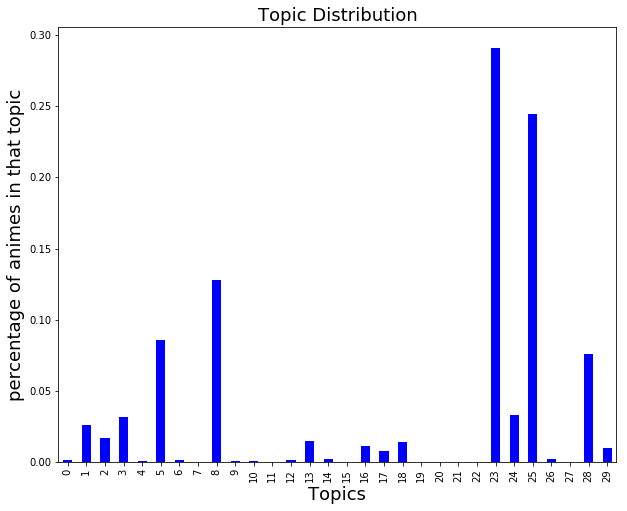

In [17]:
%env JOBLIB_TEMP_FOLDER=/tmp

class Topic(object):
    def __init__(self,no_topics, no_top_words,method):
        self.no_topics = no_topics
        self.no_top_words = no_top_words
        self.method = method
        
    def display_topics(self,model,model_matrix,feature_names):
        topic_idx_list = range(self.no_topics)
        keywords = []
        for topic in model.components_:
            output_str = " ".join([feature_names[i]
                            for i in topic.argsort()[:-self.no_top_words - 1:-1]])
            keywords.append(output_str)
        df = pd.DataFrame(index=topic_idx_list,data=keywords,columns=['key_words'])
        df2 = pd.DataFrame(model_matrix)
        df2 = pd.DataFrame(df2.idxmax(axis=1))
        df2.columns = ['counts']
        df2 = df2['counts'].value_counts()
        df = df.join(df2)
        df['prop'] = df['counts']/df['counts'].sum()
        display(df)
        f, ax = plt.subplots(figsize=(10, 8))
        df.prop.plot(kind='bar',color='blue')
        
        plt.title('Topic Distribution',size=18)
        ax.set_xlabel('Topics',size=18)
        ax.set_ylabel('percentage of animes in that topic',size=18)
        
    def nmf_topic(self,corpus):
        tfidf = TfidfVectorizer(tokenizer=tokenize,max_df=0.17,min_df=0.003,max_features=5000,stop_words='english')
        tfidf_matrix = tfidf.fit_transform(corpus)
        tfidf_feature = tfidf.get_feature_names()
        print ('num of features ',len(tfidf_feature))
        nmf = NMF(n_components=self.no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)
        nmf_matrix = nmf.transform(tfidf_matrix)
        self.display_topics(nmf,nmf_matrix ,tfidf_feature)
        print ('done')
        return nmf_matrix

    def lda_topic(self,corpus):
        countvector= CountVectorizer(tokenizer=tokenize, stop_words='english',min_df=.003,max_df=.2,max_features=5000,)#,ngram_range=(1,2)
        cv_matrix = countvector.fit_transform(corpus)
        cv_feature = countvector.get_feature_names()
#         tfidf = TfidfVectorizer(tokenizer=tokenize,max_df=1.,min_df=0.003,max_features=5000,stop_words='english')
#         cv_matrix = tfidf.fit_transform(corpus)
#         cv_feature = tfidf.get_feature_names()
        lda = LatentDirichletAllocation(n_components=self.no_topics, max_iter=20, learning_method='online', 
                                learning_offset=50.,random_state=123).fit(cv_matrix)
        lda_matrix = lda.transform(cv_matrix)
        self.display_topics(lda,lda_matrix ,cv_feature)
        return lda_matrix
    
    def run(self,corpus):
        if self.method=='nmf':
            self.nmf_topic(corpus)
        if self.method=='lda':
            self.lda_topic(corpus)
    
params = {'no_topics':30,
          'no_top_words':11,
          'method':'lda',
         }   
T = Topic(**params)
nmf_matrix = T.run(corpus)
# cv_matrix = T.count_vect_topic(corpus)

### Clustering
- Tools:
    - PCA (Dimension Reduction)
    - Multi-dimensional scaling
    - TSNE (Plotting high dimensional data)
- Clustering Algorithems:
    - K-means Clustering
      - fast
      - linear complexity *O(n)*

    - Mean-Shift Clustering
      - sliding-window-based algorithm
      - sliding window is shifted towards higher density regions
      - No need select number of clusters
    - DBSCAN
      - does not require a pe-set number of clusters
      - identifies outliers as noises


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1530 samples in 0.000s...
[t-SNE] Computed neighbors for 1530 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1530
[t-SNE] Computed conditional probabilities for sample 1530 / 1530
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.295067
[t-SNE] Error after 1000 iterations: 0.736497
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1530 samples in 0.000s...
[t-SNE] Computed neighbors for 1530 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1530
[t-SNE] Computed conditional probabilities for sample 1530 / 1530
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.291252
[t-SNE] Error after 1000 iterations: 0.734352
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1530 samples in 0.000s...
[t-SNE] Computed neighbors for 1530 samples in 0.063s...
[t-SNE]

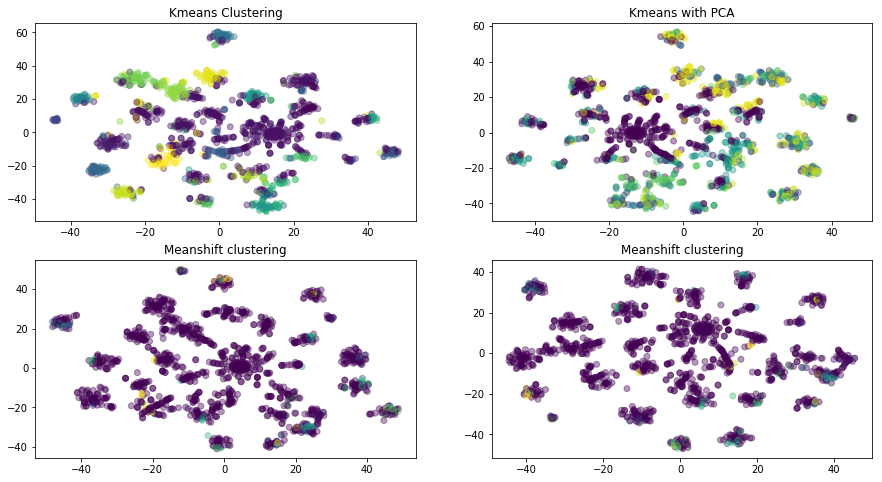

In [8]:
def pca_reduction(X):
    pca = PCA(n_components=5)
    return pca.fit_transform(X)

def kmeans_cluster(X):
    kmeans = KMeans(n_clusters=25)
    kmeans = kmeans.fit(X)
    return kmeans.predict(X)

def meanshift_cluster(X):
    meansft = MeanShift()
    meansft.fit(X)
    return meansft.predict(X)

def DBSCAN_cluster(X):
    meansft = MeanShift()
    meansft.fit(X)
    return meansft.predict(X)
    
def TSNE_plot(X,y,mytitle):
    doc_plot = manifold.TSNE (verbose=1, metric="cosine").fit_transform(X[::3,:])
    plt.scatter(doc_plot[:,0],doc_plot[:,1],c=y[::3], alpha=.4)
    plt.title(mytitle)
    return plt

def show_clustering(X):
    # Two subplots, unpack the axes array immediately
    f, axs = plt.subplots(2,2,figsize=(15,8))
    plt.subplot(2, 2, 1)
    y_labels =  kmeans_cluster(X)
    TSNE_plot(X,y_labels,"Kmeans Clustering")
    
    plt.subplot(2, 2, 2)
    pca_X = pca_reduction(X)  ##PCA reduction   
    y_labels =  kmeans_cluster(pca_X)
    TSNE_plot(X,y_labels,"Kmeans with PCA")
    
    plt.subplot(2, 2, 3)
    y_labels =  meanshift_cluster(X)
    TSNE_plot(X,y_labels,"Meanshift clustering")
    
    plt.subplot(2, 2, 4)
    y_labels =  DBSCAN_cluster(X)
    TSNE_plot(X,y_labels,"Meanshift clustering")
# show_clustering(M_user)
# show_clustering(nmf_matrix)

### Collaborative Filtering Recommender
- calculate cos similarity and Euclidean distance
- Solve matrix sparsely
- break user movie matrix 
(build a matrix, col = animes , rows = user)


In [8]:
def nmf_sparse(X, latent_features, max_iter=100, error_limit=1e-6, fit_error_limit=1e-6):
    """
    Decompose X to A*Y
    Returns user x topics , topic x movie matrix
    """
    eps = 1e-5
    print ('Starting NMF decomposition with {} latent features and {} iterations.'.format(latent_features, max_iter))
    mask = np.sign(X)
    # initial matrices. A is random [0,1] and Y is A\X.
    rows, columns = X.shape
    A = np.random.rand(rows, latent_features)
    A = np.maximum(A, eps)

    Y = linalg.lstsq(A, X)[0]
    Y = np.maximum(Y, eps)

    masked_X = mask * X
    X_est_prev = np.dot(A, Y)
    for i in range(1, max_iter + 1):
        # ===== updates =====
        # Matlab: A=A.*(((W.*X)*Y')./((W.*(A*Y))*Y'));
        top = np.dot(masked_X, Y.T)
        bottom = (np.dot((mask * np.dot(A, Y)), Y.T)) + eps
        A *= top / bottom
        A = np.maximum(A, eps)

        # Matlab: Y=Y.*((A'*(W.*X))./(A'*(W.*(A*Y))));
        top = np.dot(A.T, masked_X)
        bottom = np.dot(A.T, mask * np.dot(A, Y)) + eps
        Y *= top / bottom
        Y = np.maximum(Y, eps)
        # ==== evaluation ====
        if i % 20 == 0 or i == 1 or i == max_iter:
#             print ('Iteration {}:'.format(i))
            X_est = np.dot(A, Y)
            err = mask * (X_est_prev - X_est)
            fit_residual = np.sqrt(np.sum(err ** 2))
            X_est_prev = X_est

            curRes = linalg.norm(mask * (X - X_est), ord='fro')
#             print ('fit residual', np.round(fit_residual, 4),)
#             print ('total residual', np.round(curRes, 4))
            if curRes < error_limit or fit_residual < fit_error_limit:
                break
    return A, Y

In [9]:
from scipy import linalg

class Collaborative_model(): 
    ''' return 
        self.return_anime_names : anime_id to anime_names
        self.user_names: list of user_names
        self.anime_id: list of anime_id
    '''
    
    def anime_id_to_title(self):
        L = []
        self.return_anime_names = defaultdict(list)
        for user in db.usr.find({},{'anime_title':1,'anime_id':1,'anime_score':1,'_id':0,'user':1}):
            L = L + list(zip(user['anime_title'],user['anime_id'],user['anime_score']))
        for x in L:
            self.return_anime_names[x[1]] = x[0]
                
    def reduce_dimensions(self,df,threshold=4):
        '''threshold : minimum number of ppl watched this.anime
        '''
        df_c = df.count()
        df_c = df_c[df_c > threshold]
        df = df[df_c.index.values]
        return df
        
    def create_user_matrix(self):
        sql_db = db.usr.find({},{'anime_id':1,'anime_score':1,'_id':0,'user':1})
        df = pd.DataFrame(list(sql_db))
        self.df = df[['user','anime_id','anime_score']]
        self.user_names = df.user.values
        df['zip_col'] = df.apply(lambda row: list(zip(row['anime_id'],row['anime_score'])),axis=1)
        df = df['zip_col'].apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True).to_frame('zip_col').join(df[['user']], how='left')
        df2 = pd.DataFrame(df.zip_col.tolist(), index=df.user, columns=['anime_id','anime_score']).reset_index()
        df2 = df2.pivot(index='user', columns='anime_id',values='anime_score')
        df2 = self.reduce_dimensions(df2)
        df2.replace(0,0.1,inplace=True)
        df2.fillna(0,inplace=True)
        self.anime_id = df2.columns
        return df2.as_matrix()
    
    def output(self):
        self.anime_id_to_title()
        M_user = self.create_user_matrix()
        A, B = nmf_sparse(M_user,10)
        M_cos = pairwise.cosine_similarity(A,B.T)
        return M_cos
    


In [10]:
CF = Collaborative_model()
M_user_cos = CF.output()


Starting NMF decomposition with 10 latent features and 100 iterations.


In [11]:
# import pickle
# with open("rf.pkl", "wb") as f:
#     myvar = [CF.user_names,CF.anime_id.values,M_user_cos,CF.return_anime_names]
#     pickle.dump(myvar, f)

In [14]:
# print (CF.anime_id.values)
# print (M_user_cos.shape)
# print (CF.user_names[1000:1005])
def recommend_for_me(user_name,no_suggestions):
    user_index = np.where(CF.user_names == user_name)[0][0]
    df = pd.DataFrame(data={'animes':CF.anime_id.values,'sim_score':M_user_cos[user_index]},index=CF.anime_id.values)
    df = df.sort_values(by=['sim_score'],ascending=False)
    result  = df.animes.head(no_suggestions)
    result = [CF.return_anime_names[x] for x in result]
    return result

def output1():
    d = defaultdict(list)
    for user in CF.user_names:
        a = recommend_for_me(user,10)
        d[user] = a
    return d
d = output1()
with open("recommender1.pkl", "wb") as f:
    pickle.dump(d, f)

In [13]:
# CF.return_anime_names
# for i in CF.df[CF.df.user=='Shashank_Dilip'].anime_id.values[0]:
#     print (CF.return_anime_names[i])

In [53]:
nmf_matrix.shape

(4588, 30)

### Content Based Recommender
- based on topics



In [14]:
def compress_matrix(matrix):
    '''Compress nmf matrix (sentence vs topics) to (animes vs topics)
       Simply by average the vectors
    '''
    df = pd.DataFrame(data={'animes':name,'no_sentence':[len(doc) for doc in O]})
    df['no_sentence'] = df['no_sentence'].cumsum()
    tp = []
    start = 0
    for i in df.no_sentence:
        tp.append(np.mean(matrix[start:i],axis=0))
        start = i
    return np.array(tp)
anime_matrix = compress_matrix(nmf_matrix)
anime_matrix.shape


(2447, 30)

In [46]:
def recommend_for_me2(user_name,no_suggestions):
    watched_id = np.array(CF.df.loc[CF.df.user==user_name,'anime_id'].tolist()[0])
    watched_index = np.array([name.index(CF.return_anime_names[x]) for x in watched_id if CF.return_anime_names[x] in name] )
    user_avg = np.mean([anime_matrix[i] for i in watched_index],axis=0).reshape((1,30))
    arr = pairwise.cosine_similarity(user_avg,anime_matrix)
    arr = np.argsort(arr[0])
    result = [name[i] for i in arr[-no_suggestions::]]
    print (result)
#     
#     print (df)

    
recommend_for_me2('Shashank_Dilip',10)

['Ping Pong', 'Hajime no Ippo', 'Hashire Melos (Movie)', 'Gekijouban Pocket Monsters Diamond & Pearl: Arceus Choukoku no Jikuu e', 'Cardcaptor Sakura', 'Mirumo de Pon!', 'Shakugan no Shana', 'Naruto: Shippuuden Movie 4 - The Lost Tower', 'Ning', 'Joe']


In [48]:
# with open("rf2.pkl", "wb") as f:
#     myvar = [CF.user_names,CF.anime_id.values,M_user_cos,CF.return_anime_names]
#     pickle.dump(myvar, f)

In [56]:
# print (df1[df1.duplicated()].head(10))

In [58]:
nmf_matrix.shape

(4588, 30)